# Stroke Prediction: A Binary Classification Problem

In this notebook, I will work on a supervised binary classification problem to predict whether a subject is a stroke patient or not. In order to do so, I will leverage three models: one linear model (Logistic Regression) and two non-linear ones (Neural Network and Random Forest).

I will engage in the following steps, chronologically:

1. [Setup: Importing Libraries and Data](#1)
2. [Exploratory Data Analysis (EDA)](#2)
3. [Data Preprocessing](#3)
4. [Feature Engineering & Selection](#4)
5. [Model Selection](#5)
6. [Model Evaluation](#6)
7. [Conclusion](#7)


## Setup: Importing Libraries and Data <a id="1"></a>

First: import all necessary dependencies.


In [56]:
%load_ext autoreload
%autoreload 2

import random
import sys
from pathlib import Path

base_path = Path().resolve().parent
sys.path.append(str(base_path))


import numpy as np
import sklearn
import torch
from loguru import logger
import pandas as pd

from src.data_preparation import load_data, min_max_normalize, StrokeDataset, replace_na, transform_non_numericals, split_X_y, create_polynomials, transform_polynomials, pca
from sklearn.model_selection import train_test_split
from src.training import BinaryLogisticRegression, BinaryNeuralNetwork, NaiveBaseline, scores, LogisticRegression, NeuralNetwork, weighted_binary_cross_entropy_loss, k_fold_cross_validation, feature_selection
from src.data_understanding import plot_distributions, print_na, print_non_numericals, plot_scatter_and_pair, plot_relative_distributions
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In order to optimize training times, let's use the best available device, leveraging the machine's physical resources.


In [57]:
# setting parallel inference method
device = None
if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    print("Using MPS")
    device = torch.device("mps")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using MPS


## Exploratory Data Analysis (EDA) <a id="2"></a>


### Data Exploration

By creating a first graphical representation of the data at hand, we can understand the underlying distributions.


In [58]:
# load data
path_data_train = "data/train.csv"
path_data_test = "data/test.csv"

data_train_raw = load_data(base_path / path_data_train)
data_test_raw = load_data(base_path / path_data_test)

data_train_raw.drop(columns=["id"], inplace=True)
data_test_raw.drop(columns=["id"], inplace=True)

2024-07-29 13:14:49.521 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.

2024-07-29 13:14:49.524 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.



Let's plot the distributions of the raw data to get an initial understanding of what we are working with.


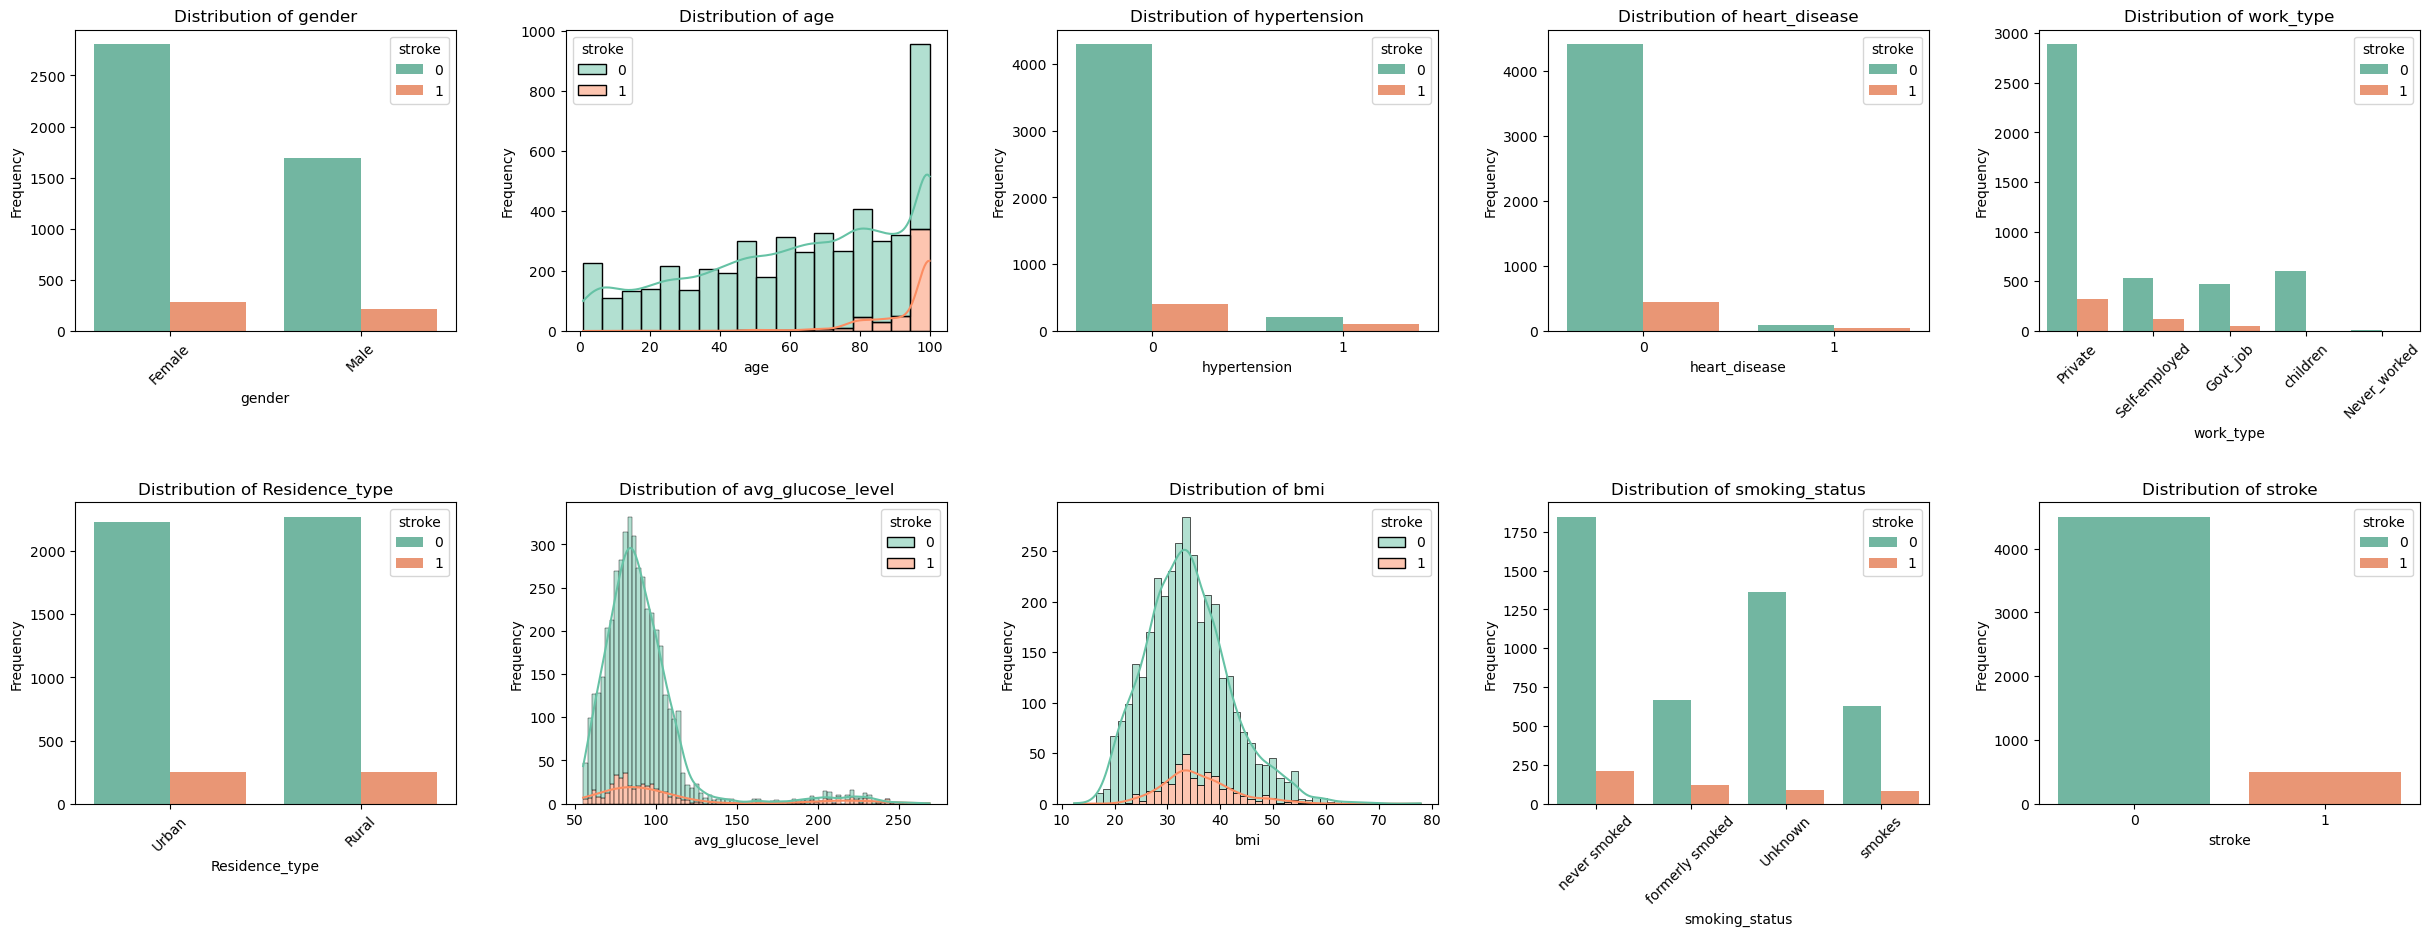

In [59]:
plot_distributions(data_train_raw)

Some important first insights:

-   The dataset is highly imbalanced: There are many more instances of people who did not have a stroke than those who did. This will require special attention during model training and evaluation.
-   We have a mix of numerical and categorical features. We will need to preprocess them accordingly.
-   Regarding the numerical features:
    -   The features have different scales. We will normalize them.
-   Regarding the categorical features:
    -   Some categorical features are binary, while others have more than two values.
    -   The categorical features with more than two values are nominal, i.e., there is no inherent order in the categories. We will one-hot encode them.
        -   Note: The `smoking_status` feature could be interpreted as ordinal in some sense ("time since last cigarette"), however, the influence of this underlying order on the target variable is not clear. We will treat it as a nominal feature.


To make sure that the training and test data come from the same underlying distribution, let's plot the test data as well.


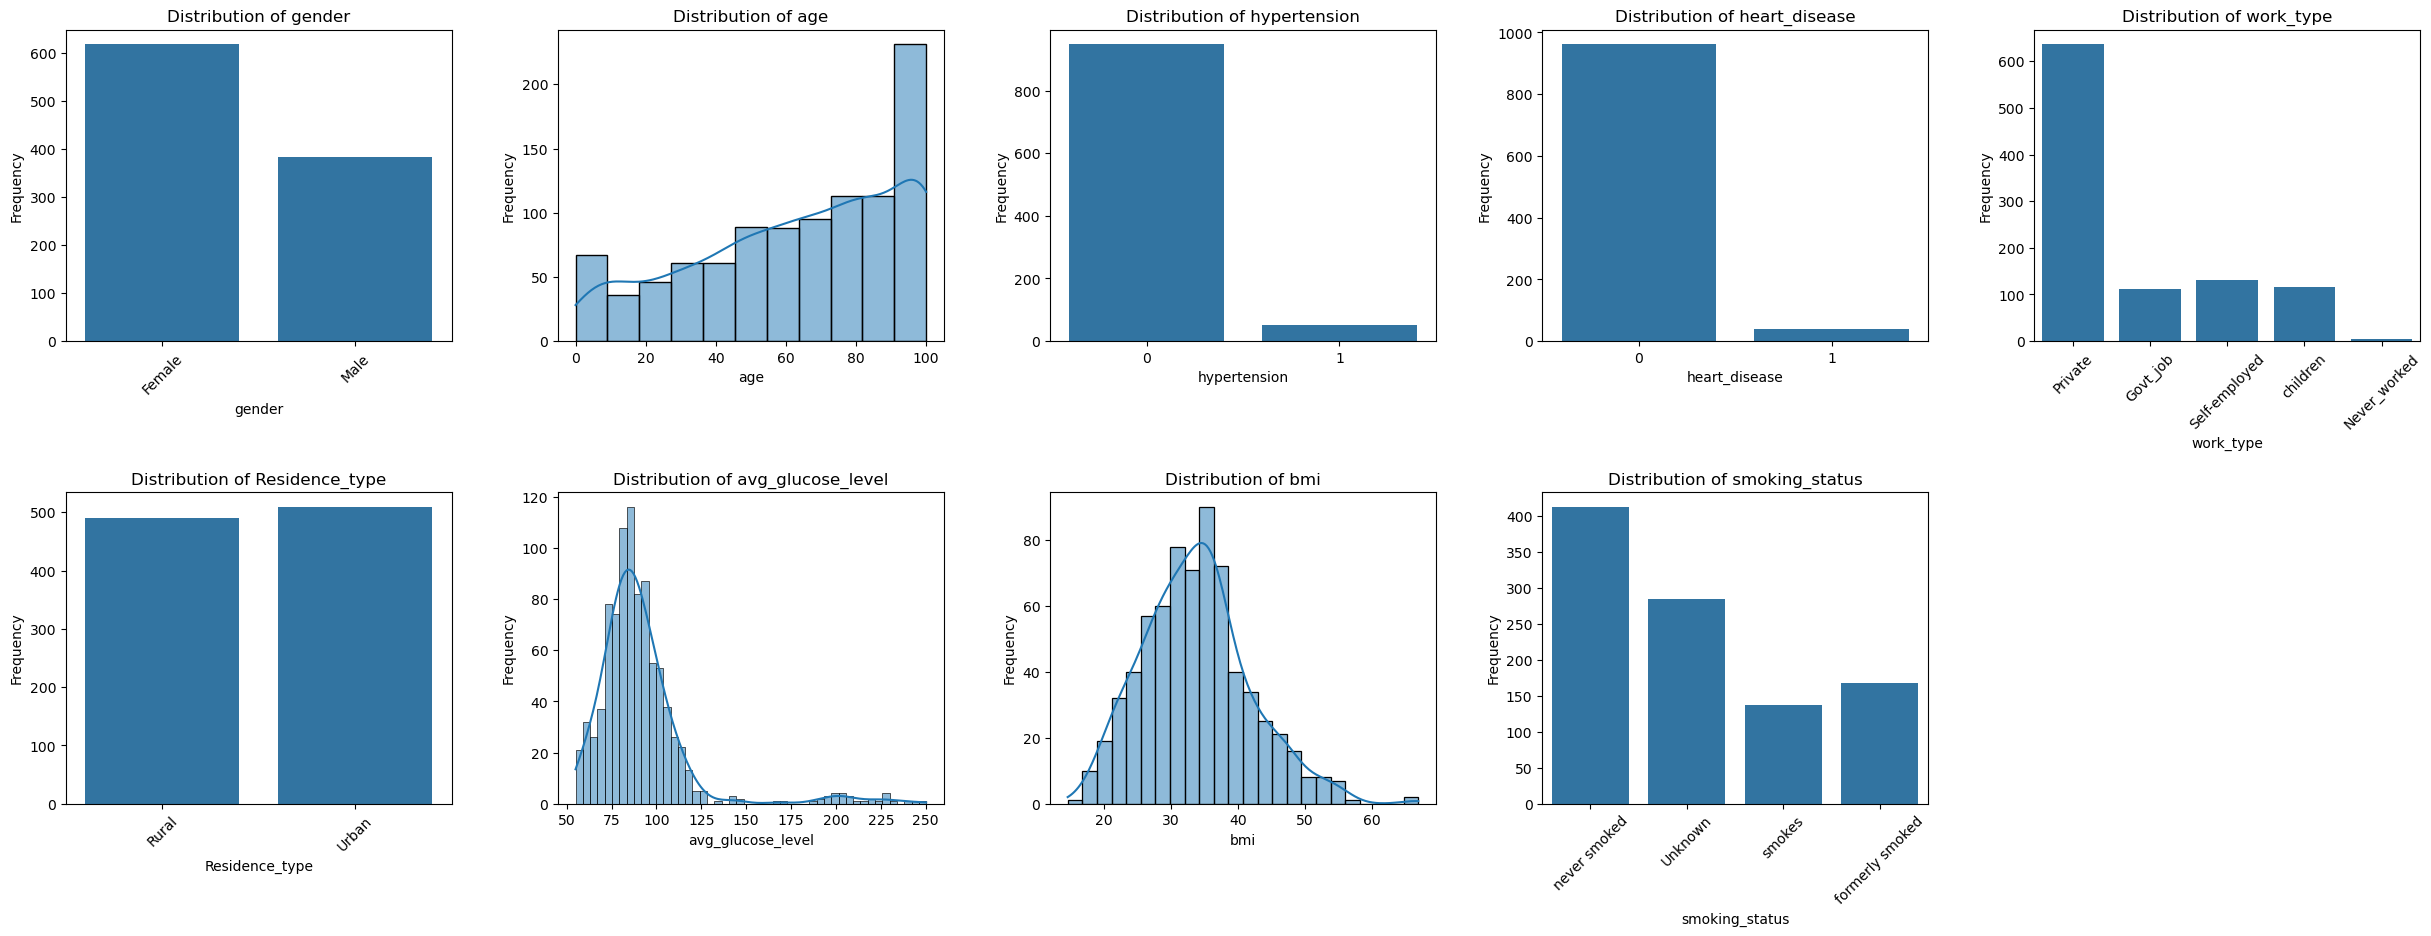

In [60]:
plot_distributions(data_test_raw)

Looking good: No significant covariate shift is apparent. The distribution of some features, such as `smoking_status` and `work_type`, may differ slightly between the training and test data, but it seems more likely our relatively small sample size creates this illusion.

Next, I'll have a look at the relative distributions of the target variable `stroke` over the features of the training data.


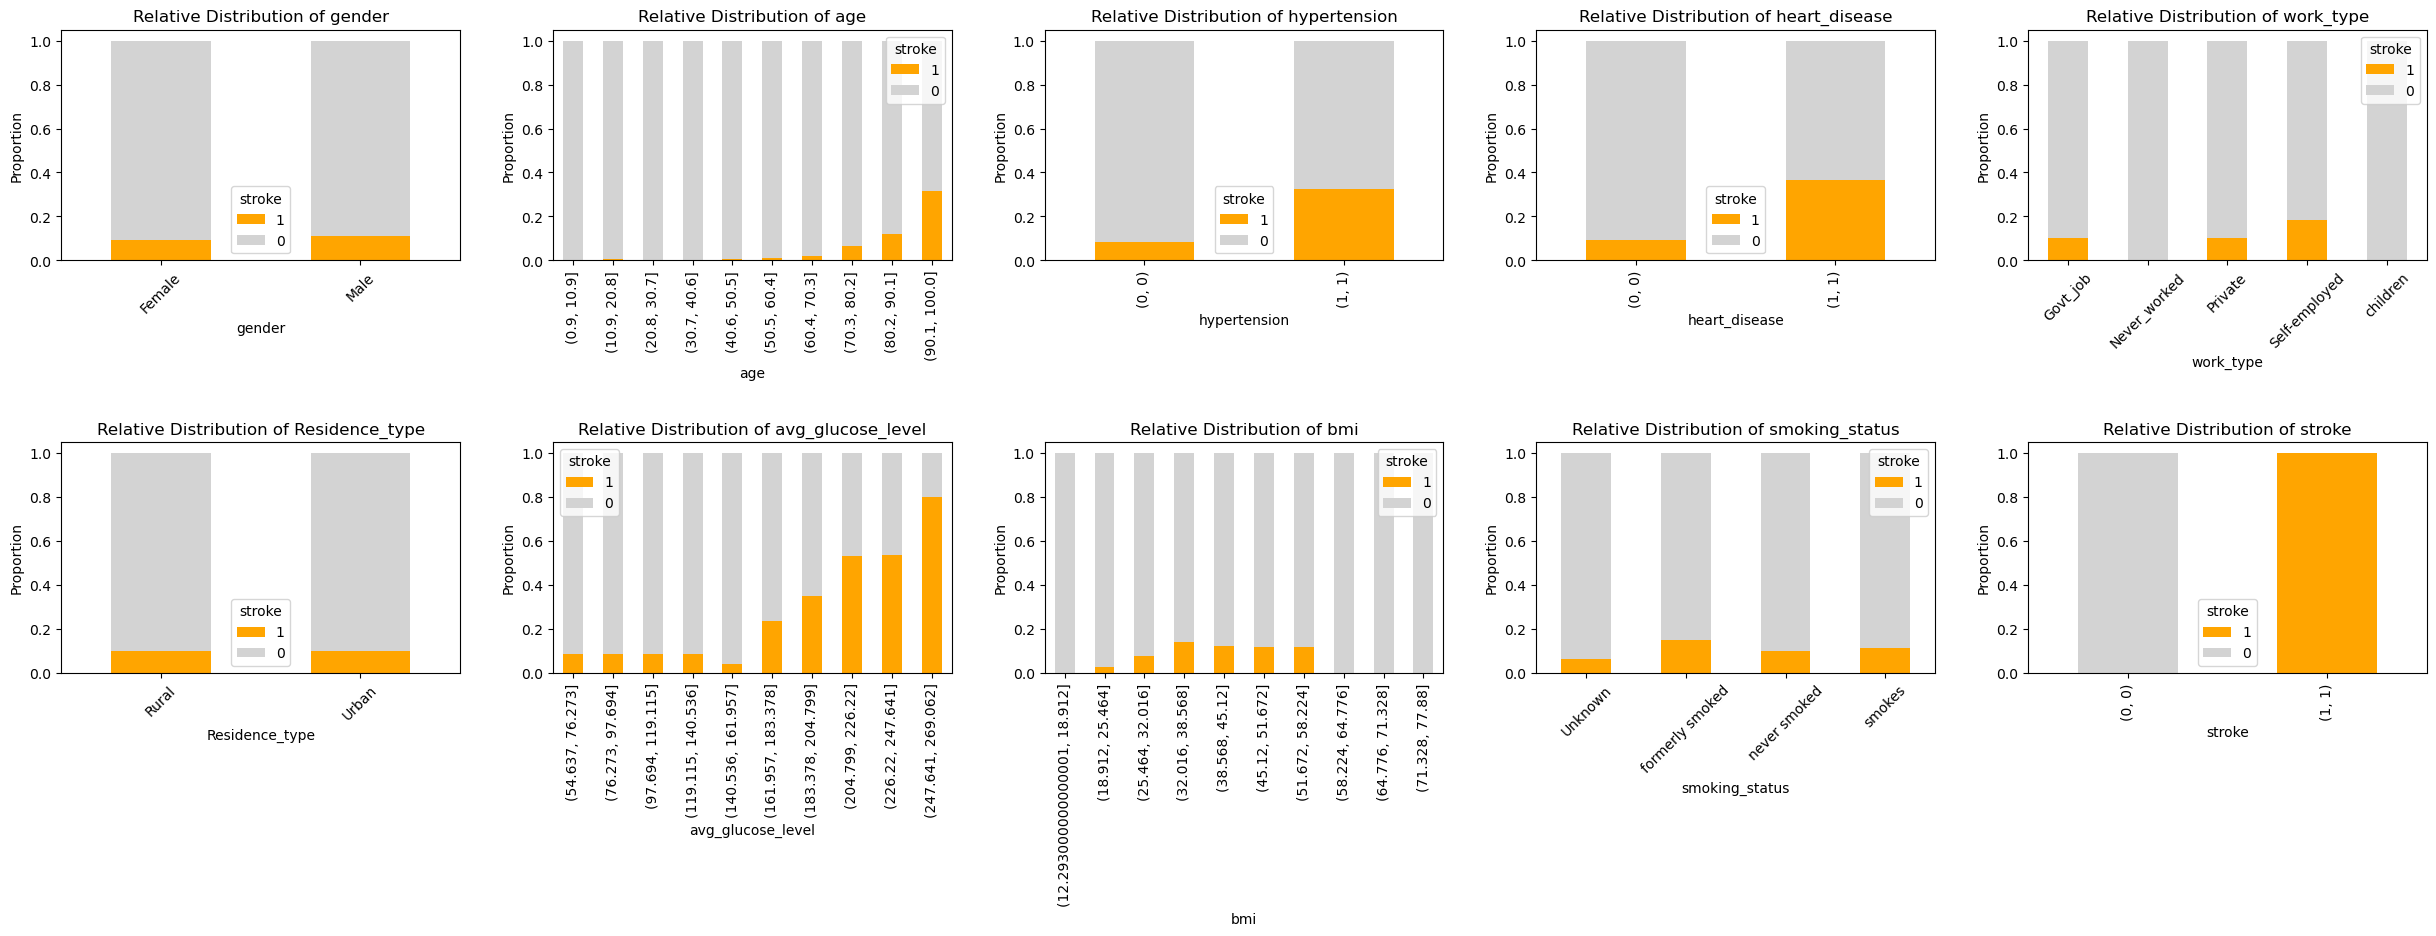

In [61]:
plot_relative_distributions(data_train_raw)

Some more important insights:

-   Regarding the continuous features:
    -   The influence of `age` and `bmi` on the likelihood of `stroke` seems to be positive and may be non-linear.
    -   `avg_glucose_level` might have a positive linear influence on the target variable, starting at a certain threshold.
-   Regarding the categorical features:
    -   `hypertension` and `heart_disease` seem to have a significant positive influence on the target variable.
    -   `work_type`: People who are self-employed seem to have a slightly higher chance of having a stroke. People who never worked or care for their children have a lower chance. Government workers and private workers seem to have a similar distribution.
    -   Both `gender` and `Residence_type` seem to have no significant influence on the target variable in isolation. However, there might be interaction effects with other features.

These are just first impressions. We did not test significance. Furthermore, we only yet looked at the features and their potential relationships with the target variable in isolation. By analyzing interaction effects later, we can get a more accurate understanding of the data and create better features for our models, which is especially important for the logistic regression model, given its linear nature.


In [62]:
print_na(data_train_raw)
print_non_numericals(data_train_raw)

2024-07-29 13:14:51.823 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column gender: 0 / 5000
2024-07-29 13:14:51.823 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column age: 0 / 5000
2024-07-29 13:14:51.824 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column hypertension: 0 / 5000
2024-07-29 13:14:51.824 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column heart_disease: 0 / 5000
2024-07-29 13:14:51.825 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column work_type: 0 / 5000
2024-07-29 13:14:51.826 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column Residence_type: 0 / 5000
2024-07-29 13:14:51.826 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column avg_glucose_leve

We can see there are a lot of missing values in our training data: 2756 / 5000 data points have at least one missing value. We will need to address this issue in the preprocessing step. Since there are so many data points with missing values, we will not simply drop those.

-   For the continuous features `avg_glucose_level` and `bmi`, we will impute the missing values with the median of the respective feature.
-   For the categorical feature `smoking_status`, the missing values currently make up a separate category called "Unknown". We will treat this category as a separate category in the one-hot encoding step.


## Data Preprocessing <a id="3"></a>


In this section, we will preprocess the data to prepare it for model training. We will:

-   Transform non-numerical features into numerical ones. This is done using one-hot encoding.
-   Replace missing values in the continuous features with the median of that respective feature.
-   Normalize the numerical features using min-max normalization. This way, all features will have the same scale, which also avoids gradient problems during neural network training.


In [63]:
data_train_preprocessed = transform_non_numericals(data_train_raw)
data_train_preprocessed = replace_na(data_train_preprocessed, replace_with="median")
data_train_preprocessed = min_max_normalize(data_train_preprocessed)

data_test_preprocessed = transform_non_numericals(data_test_raw)
data_test_preprocessed = replace_na(data_test_preprocessed, replace_with="median")
data_test_preprocessed = min_max_normalize(data_test_preprocessed)

2024-07-29 13:14:51.853 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed gender into binary encoding
2024-07-29 13:14:51.855 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:53 - Transformed work_type into one-hot encoding
2024-07-29 13:14:51.856 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed Residence_type into binary encoding
2024-07-29 13:14:51.858 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:53 - Transformed smoking_status into one-hot encoding
2024-07-29 13:14:51.859 | INFO     | src.data_preparation.data_preprocessing:replace_na:36 - Replaced NaN values with median
2024-07-29 13:14:51.862 | INFO     | src.data_preparation.data_preprocessing:min_max_normalize:69 - Normalized data using min-max normalization
2024-07-29 13:14:51.863 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:49 - Transformed gen

## Feature Engineering & Selection <a id="4"></a>


Next, we will create new features by combining existing ones, using polynomials and Principal Component Analysis (PCA). This way, we can map non linear-relationships between the features and the target to linear relationships, which is especially important to improve the performance of the logistic regression model.

After creating the new features, we will do some feature selection to reduce the dimensionality of the feature space. This will help avoid overfitting and reduce training times. We will then be left with the most important features, including the originals and the engineered ones.

Finally, we will plot the distribution of these residing features in relation to the target variable `stroke`, to see if the new features reveal important relationships to the target variable. We will also plot these residing features in a pair plot with the target variable to see if we can identify interaction patterns.


### Feature Engineering: Polynomial Features


We are going to create polynomial features of degree 2. This means: For each pair of features, we will create a new feature that is the product of the two features.
Example: Given features $x_1$ and $x_2$, we will end up with the following features: $x_1$, $x_2$, $x_1 x_2$, $x_1^2$, and $x_2^2$.


In [64]:
d_poly = 2

# feature cols without target
feature_columns = data_train_preprocessed.columns.drop("stroke")

polynomials_train, feature_names = create_polynomials(
    data_train_preprocessed, feature_columns, degree=d_poly
)
polynomials_test = transform_polynomials(
    data_test_preprocessed, feature_columns, feature_names
)

logger.info(f"Data preprocessed train shape: {data_train_preprocessed.shape}")
logger.info(f"Data preprocessed test shape: {data_test_preprocessed.shape}")
logger.info(f"Polynomials train shape: {polynomials_train.shape}")
logger.info(f"Polynomials test shape: {polynomials_test.shape}")

2024-07-29 13:14:52.037 | INFO     | __main__:<module>:13 - Data preprocessed train shape: (5000, 17)
2024-07-29 13:14:52.037 | INFO     | __main__:<module>:14 - Data preprocessed test shape: (1000, 16)
2024-07-29 13:14:52.038 | INFO     | __main__:<module>:15 - Polynomials train shape: (5000, 153)
2024-07-29 13:14:52.038 | INFO     | __main__:<module>:16 - Polynomials test shape: (1000, 152)


We can see that we got quite a lot more features! Those are clearly too many to include (even too many to plot!). After applying Principal Component Analysis (PCA) in the next step, we will reduce the dimensionality of the feature space. In order to avoid the "Qual der Wahl" (the agony of choice), we will simply let the Logistic Regression model decide which features are important.


In [65]:
n_pcs = 10

pcs_train = pca(polynomials_train, n_components=n_pcs)
pcs_test = pca(polynomials_test, n_components=n_pcs)

logger.info(f"Principal components train shape: {pcs_train.shape}")
logger.info(f"Principal components test shape: {pcs_test.shape}")

# data_train_engineered = data_train_preprocessed.join(pcs_train)
# data_test_engineered = data_test_preprocessed.join(pcs_test)

2024-07-29 13:14:52.117 | INFO     | __main__:<module>:6 - Principal components train shape: (5000, 10)
2024-07-29 13:14:52.117 | INFO     | __main__:<module>:7 - Principal components test shape: (1000, 10)


In order to train our Logistic Regression model on all these new features, we will need to group them together with the original features.


In [66]:
data_train_tmp = pd.concat([polynomials_train, pcs_train], axis=1)
data_test_tmp = pd.concat([polynomials_test, pcs_test], axis=1)

feature_names_tmp = data_train_tmp.drop(columns=["stroke"]).columns.to_list()

X_tmp = data_train_tmp.drop(columns=["stroke"]).copy().to_numpy()
y_tmp = data_train_tmp["stroke"].copy().to_numpy()
X_test_tmp = data_test_tmp.copy().to_numpy()

logger.info(f"First ten features in data_train_tmp: {feature_names_tmp[0:10]}")
logger.info(f"Last ten features in data_train_tmp: {feature_names_tmp[-10:]}")
logger.info(f"First ten features in data_test_tmp: {data_test_tmp.columns[0:10]}")
logger.info(f"Last ten features in data_test_tmp: {data_test_tmp.columns[-10:]}")

2024-07-29 13:14:52.164 | INFO     | __main__:<module>:10 - First ten features in data_train_tmp: ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private']
2024-07-29 13:14:52.165 | INFO     | __main__:<module>:11 - Last ten features in data_train_tmp: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']
2024-07-29 13:14:52.166 | INFO     | __main__:<module>:12 - First ten features in data_test_tmp: Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private'],
      dtype='object')
2024-07-29 13:14:52.170 | INFO     | __main__:<module>:13 - Last ten features in data_test_tmp: Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], dtype='object')


### Feature Selection


To select the most important features, we will train our Logistic Regression model with L2 regularization, which will force the model to set many features' weights to or close to 0, then drop the features with the weakest weights.


i = 0 – Empirical Risk Estimate: 0.028510464592255858, Previous Estimate: inf – new number of features to delete – new lowest risk estimate
i = 5 – Empirical Risk Estimate: 0.040578943866354154, Previous Estimate: 0.028510464592255858 – new number of features to delete
i = 10 – Empirical Risk Estimate: 0.053439934466600246, Previous Estimate: 0.040578943866354154
i = 15 – Empirical Risk Estimate: 0.04557002249989134, Previous Estimate: 0.053439934466600246 – new number of features to delete
i = 20 – Empirical Risk Estimate: 0.11223023104476429, Previous Estimate: 0.04557002249989134
i = 25 – Empirical Risk Estimate: 0.040611948501834826, Previous Estimate: 0.11223023104476429 – new number of features to delete
i = 30 – Empirical Risk Estimate: 0.027650628723871577, Previous Estimate: 0.040611948501834826 – new number of features to delete – new lowest risk estimate
i = 35 – Empirical Risk Estimate: 0.03369525110083136, Previous Estimate: 0.027650628723871577 – new number of features to

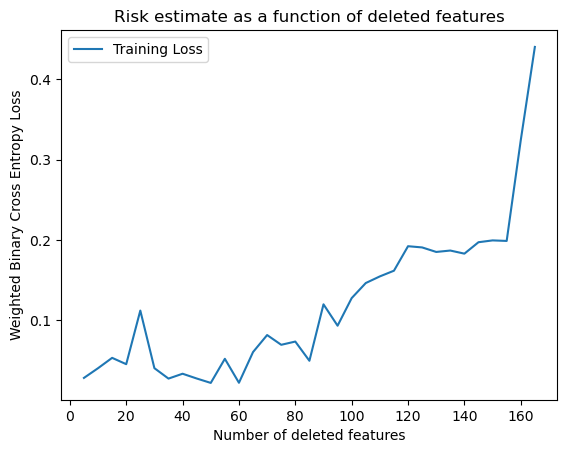

2024-07-29 13:16:22.969 | INFO     | __main__:<module>:20 - Shape of X_train_tmp after feature selection: (4000, 116)
2024-07-29 13:16:22.970 | INFO     | __main__:<module>:21 - Shape of X_val_tmp after feature selection: (1000, 116)
2024-07-29 13:16:22.971 | INFO     | __main__:<module>:22 - Shape of X_test_tmp after feature selection: (1000, 116)


In [67]:
n_features_per_iteration = 5  # delete 5 features per iteration
risk_estimate_error_margin = 0.02  # metric: weighted binary cross entropy loss

features_to_delete, risk_estimates = feature_selection(
    X_tmp,
    y_tmp,
    n_features_per_iteration=n_features_per_iteration,
    risk_estimate_error_margin=risk_estimate_error_margin,
    plot=True,
)

# drop the features
X_tmp = np.delete(X_tmp, features_to_delete, axis=1)
X_test_tmp = np.delete(X_test_tmp, features_to_delete, axis=1)

X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(
    X_tmp, y_tmp, test_size=0.2, random_state=42
)

logger.info(f"Shape of X_train_tmp after feature selection: {X_train_tmp.shape}")
logger.info(f"Shape of X_val_tmp after feature selection: {X_val_tmp.shape}")
logger.info(f"Shape of X_test_tmp after feature selection: {X_test_tmp.shape}")

Let's create new references `X_train_selected`, `X_val_selected` and `X_test_selected`.


In [68]:
X_train_selected = X_train_tmp
X_val_selected = X_val_tmp
X_test_selected = X_test_tmp

y_train_selected = y_train_tmp
y_val_selected = y_val_tmp

## Model Selection <a id="5"></a>


### Naive Baseline


2024-07-29 13:16:55.853 | INFO     | src.training.evaluate:scores:43 - Naive Baseline – Accuracy: 0.817
F1 score: 0.09852216748768473
Precision: 0.08928571428571429
Recall: 0.10989010989010989
AUC: 0.5
            Pred Neg  Pred Pos
Actual Neg       807       102
Actual Pos        81        10


Validation accuracy: 0.857


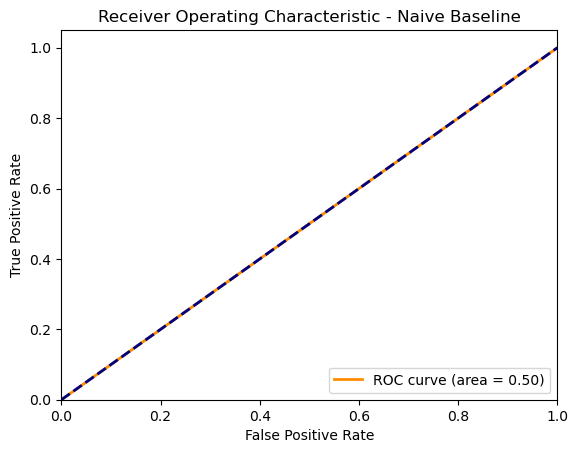

(0.817, 0.09852216748768473, 0.5)

In [69]:
# Naive Baseline
naive_baseline = NaiveBaseline()
naive_baseline.fit(X_train_selected, y_train_selected, X_val_selected, y_val_selected)
y_pred = naive_baseline.predict(X_val_selected)
y_pred_proba = naive_baseline.predict_proba(X_val_selected)
scores("Naive Baseline", y_val_selected, y_pred, y_pred_proba, plot=True)

## Logistic Regression


In [70]:
lr = 0.01
n_epochs = 12
batch_size = 8
lambda_reg = 0.001

Epoch 0: Train Loss: 0.7051892290870976, Val Loss: 2.1000698180629143
Epoch 1: Train Loss: 0.9992119624662837, Val Loss: 0.5658495343098597
Epoch 2: Train Loss: 0.5822680689423826, Val Loss: 0.5569588911672216
Epoch 3: Train Loss: 0.25779427661146775, Val Loss: 0.3619306408777331
Epoch 4: Train Loss: 0.2954558395099042, Val Loss: 0.13651336294660463
Epoch 5: Train Loss: 0.09403760640357134, Val Loss: 0.04051692490423488
Epoch 6: Train Loss: 0.029258453140156758, Val Loss: 0.10782721379030404
Epoch 7: Train Loss: 0.11577042769104119, Val Loss: 0.13100867085741308
Epoch 8: Train Loss: 0.09343495378465427, Val Loss: 0.3515369236105568
Epoch 9: Train Loss: 0.08240464315958525, Val Loss: 0.0019846384157055337
Epoch 10: Train Loss: 0.003899140146411164, Val Loss: 0.006852726781878302
Epoch 11: Train Loss: 0.005122749216766769, Val Loss: 0.0030728758252141822


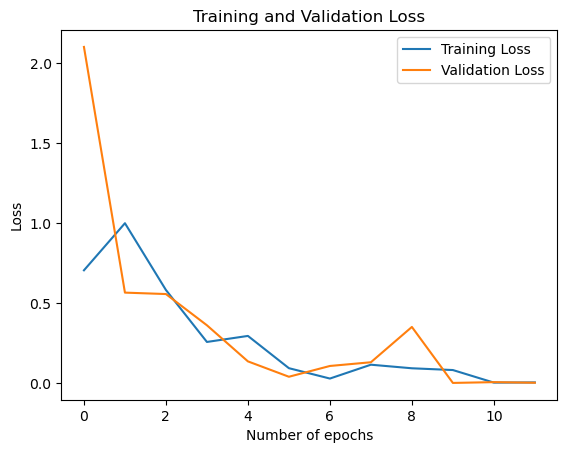

2024-07-28 22:50:30.894 | INFO     | src.training.evaluate:scores:43 - Logistic Regression – Accuracy: 0.999
F1 score: 0.994535519125683
Precision: 0.9891304347826086
Recall: 1.0
AUC: 1.0
            Pred Neg  Pred Pos
Actual Neg       908         1
Actual Pos         0        91


Training complete.


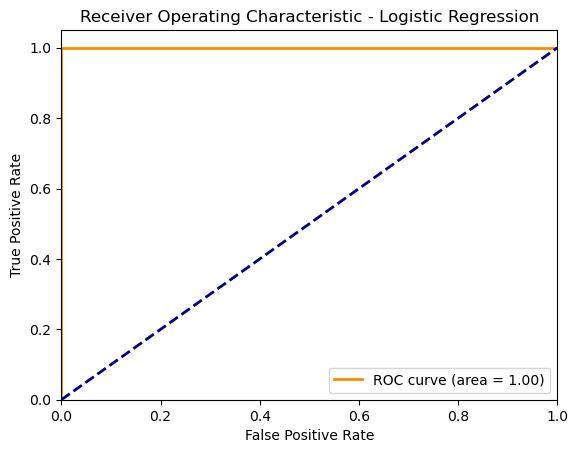

In [170]:
# Logisic Regression Hyper Param Tuning
log_reg = BinaryLogisticRegression(
    X_train_selected.shape[1],
    epochs=n_epochs,
    learning_rate=lr,
    batch_size=batch_size,
    lambda_reg=lambda_reg,
)

log_reg.fit(
    X_train_selected, y_train_selected, X_val_selected, y_val_selected, plot=True
)

y_pred = log_reg.predict(X_val_selected)
y_pred_proba = log_reg.predict_proba(X_val_selected)
acc, f1, auc = scores(
    "Logistic Regression", y_val_selected, y_pred, y_pred_proba, plot=True
)

## Neural Network


In [213]:
epochs = 100
d_hidden = 32
n_hidden = 1
learning_rate = 0.002
batch_size = 8
lambda_reg = 0.001

Shape of self.W[1]: (135, 32)
Shape of self.B[1]: (32,)
Shape of self.W[2]: (32, 1)
Shape of self.B[2]: (1,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z: (8,)
Shape of d_L_d_z:

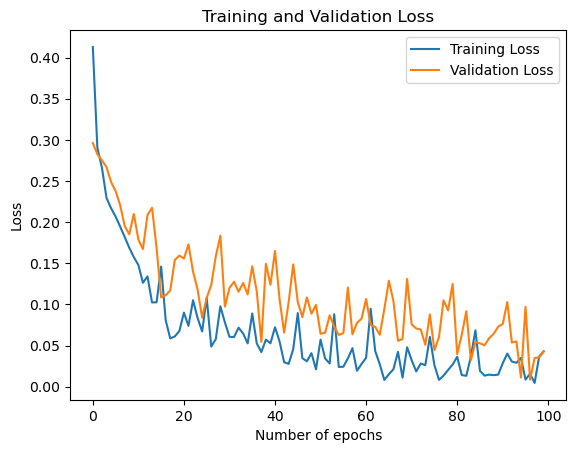

2024-07-28 22:58:53.432 | INFO     | src.training.evaluate:scores:43 - neural_net – Accuracy: 0.996
F1 score: 0.9782608695652174
Precision: 0.967741935483871
Recall: 0.989010989010989
AUC: 0.9990207811989991
            Pred Neg  Pred Pos
Actual Neg       906         3
Actual Pos         1        90


Training complete.


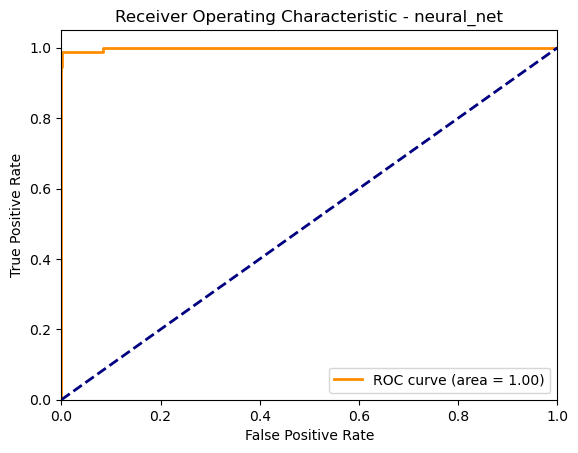

In [214]:
neural_net = BinaryNeuralNetwork(
    X_train_selected.shape[1],
    d_hidden,
    n_hidden,
    epochs=epochs,
    learning_rate=learning_rate,
    batch_size=batch_size,
    lambda_reg=lambda_reg,
)

neural_net.fit(
    X_train_selected, y_train_selected, X_val_selected, y_val_selected, plot=True
)

y_pred = neural_net.predict(X_val_selected)
y_pred_proba = neural_net.predict_proba(X_val_selected)
acc, f1, auc = scores("neural_net", y_val_selected, y_pred, y_pred_proba, plot=True)

Epoch: 0. Train Loss: 0.6903813788890839. Val Loss: 0.7418607901781797. Val Accuracy: 88.6
Epoch: 1. Train Loss: 0.6889947507381439. Val Loss: 0.7376723075285554. Val Accuracy: 88.6
Epoch: 2. Train Loss: 0.6861642217636108. Val Loss: 0.733853411860764. Val Accuracy: 84.3
Epoch: 3. Train Loss: 0.6845444242954254. Val Loss: 0.7258312562480569. Val Accuracy: 15.7
Epoch: 4. Train Loss: 0.6816976294517517. Val Loss: 0.7232839316129684. Val Accuracy: 34.5
Epoch: 5. Train Loss: 0.67881880235672. Val Loss: 0.7206195248290896. Val Accuracy: 56.5
Epoch: 6. Train Loss: 0.6745678112506867. Val Loss: 0.7215007310733199. Val Accuracy: 86.0
Epoch: 7. Train Loss: 0.6703411495685577. Val Loss: 0.7148541249334812. Val Accuracy: 80.6
Epoch: 8. Train Loss: 0.6652791640758514. Val Loss: 0.7082075932994485. Val Accuracy: 77.4
Epoch: 9. Train Loss: 0.6599648728370666. Val Loss: 0.6986709805205464. Val Accuracy: 61.3
Epoch: 10. Train Loss: 0.6546229622364044. Val Loss: 0.7013527723029256. Val Accuracy: 85.3
E

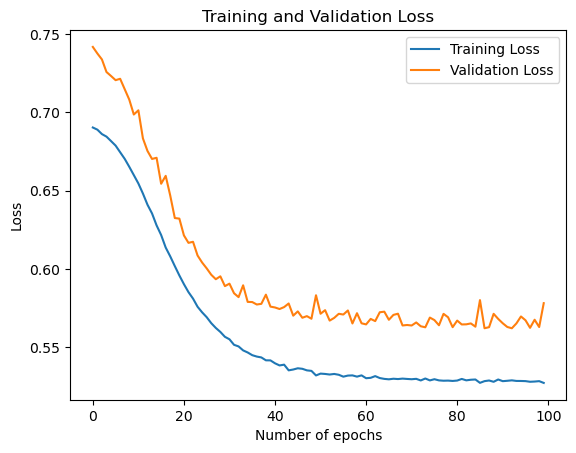

2024-07-28 12:25:28.912 | INFO     | src.training.evaluate:scores:41 - Neural Network – Accuracy: 0.813
F1 score: 0.4672364672364672
Precision: 0.3459915611814346
Recall: 0.7192982456140351
AUC: 0.8569759613480654
            Pred Neg  Pred Pos
Actual Neg       731       155
Actual Pos        32        82


(0.813, 0.4672364672364672, 0.8569759613480654)

In [13]:
# Neural Network
X = data_train_preprocessed.drop(columns=["stroke"]).copy().to_numpy()
y = data_train_preprocessed["stroke"].copy().to_numpy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = data_test_preprocessed.copy().to_numpy()

logger.info(f"X_train shape: {X_train.shape}")
logger.info(f"X_test shape: {X_test.shape}")
logger.info(f"Shape of y_train: {y_train.shape}")
logger.info(f"Shape of y_val: {y_val.shape}")

neural_network = NeuralNetwork(
    n_features=X_train.shape[1],
    n_hidden=d_hidden,
    lr=learning_rate,
    epochs=epochs,
    batch_size=batch_size,
    lambda_reg=lambda_reg,
)
neural_network.fit(dataset_train, dataset_val, plot=True)
y_pred = neural_network.predict(X_val)
y_pred_proba = neural_network.predict_proba(X_val)
scores("Neural Network", y_val, y_pred, y_pred_proba, plot=True)

## Random Forest
